In [2]:
import pandas as pd 

load dataset

In [3]:
df = pd.read_csv(r"C:\Users\yasht\Downloads\Funnel analysis\funnel_events_1000_monotonic.csv")
df.head(10)

,user_id,session_id,event_time,event_type,device,traffic_source,location
0,U00059,t6uvubthhg3f,2025-12-16 16:08:15,visit,mobile,organic,IN-TN
1,U00059,t6uvubthhg3f,2025-12-16 16:09:30,view_product,mobile,organic,IN-TN
2,U00059,t6uvubthhg3f,2025-12-16 16:12:59,add_to_cart,mobile,organic,IN-TN
3,U00135,9rnxgrfob3y9,2025-12-09 15:00:22,visit,desktop,referral,IN-KA
4,U00135,9rnxgrfob3y9,2025-12-09 15:04:07,view_product,desktop,referral,IN-KA
5,U00135,9rnxgrfob3y9,2025-12-09 15:07:06,add_to_cart,desktop,referral,IN-KA
6,U00135,9rnxgrfob3y9,2025-12-09 15:10:37,checkout,desktop,referral,IN-KA
7,U00383,yog7sebkmcrg,2025-12-17 07:24:52,visit,mobile,organic,IN-AP
8,U00383,yog7sebkmcrg,2025-12-17 07:26:26,view_product,mobile,organic,IN-AP
9,U00383,yog7sebkmcrg,2025-12-17 07:31:53,add_to_cart,mobile,organic,IN-AP


to get info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         1000 non-null   object
 1   session_id      1000 non-null   object
 2   event_time      1000 non-null   object
 3   event_type      1000 non-null   object
 4   device          1000 non-null   object
 5   traffic_source  1000 non-null   object
 6   location        1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB


In [5]:
df.head()


,user_id,session_id,event_time,event_type,device,traffic_source,location
0,U00059,t6uvubthhg3f,2025-12-16 16:08:15,visit,mobile,organic,IN-TN
1,U00059,t6uvubthhg3f,2025-12-16 16:09:30,view_product,mobile,organic,IN-TN
2,U00059,t6uvubthhg3f,2025-12-16 16:12:59,add_to_cart,mobile,organic,IN-TN
3,U00135,9rnxgrfob3y9,2025-12-09 15:00:22,visit,desktop,referral,IN-KA
4,U00135,9rnxgrfob3y9,2025-12-09 15:04:07,view_product,desktop,referral,IN-KA


shape + columns (sanity check)

In [6]:
print("Rows, Cols:", df.shape)
print(df.columns)


Rows, Cols: (1000, 7)
Index(['user_id', 'session_id', 'event_time', 'event_type', 'device',
       'traffic_source', 'location'],
      dtype='object')


Check data types

In [7]:
df.dtypes

user_id           object
session_id        object
event_time        object
event_type        object
device            object
traffic_source    object
location          object
dtype: object

| Stage        | Business intent |
| ------------ | --------------- |
| visit        | Awareness       |
| view_product | Interest        |
| add_to_cart  | Consideration   |
| checkout     | High intent     |
| purchase     | Conversion      |


Understand the funnel stages

In [8]:
df["event_type"].unique()


array(['visit', 'view_product', 'add_to_cart', 'checkout', 'purchase'],
      dtype=object)

distribution check 

In [9]:
df["event_type"].value_counts()


event_type
visit           400
view_product    250
add_to_cart     180
checkout        110
purchase         60
Name: count, dtype: int64

In [10]:
df["user_id"].nunique()


400

In [11]:
df.isna().sum()


user_id           0
session_id        0
event_time        0
event_type        0
device            0
traffic_source    0
location          0
dtype: int64

In [12]:
df.duplicated().sum()


0

Convert event_time to datetime

In [13]:
df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
df["event_time"].isna().sum()


0

funnel order

In [14]:
funnel_order = ["visit", "view_product", "add_to_cart", "checkout", "purchase"]


Convert event_type to ordered category

In [15]:
df["event_type"] = pd.Categorical(
    df["event_type"],
    categories=funnel_order,
    ordered=True
)


Drop invalid rows

In [16]:
df_clean = (
    df
    .dropna(subset=["user_id", "event_type", "event_time"])
)


Sort events correctly 

In [17]:
df_clean = df_clean.sort_values(
    by=["user_id", "event_time"]
)


Remove duplicate user

In [18]:
df_clean = df_clean.drop_duplicates(
    subset=["user_id", "event_type"],
    keep="first"
)


In [19]:
df_clean = df_clean.reset_index(drop=True)


Sanity checks

Event type distribution

In [20]:
df_clean["event_type"].value_counts()


event_type
visit           400
view_product    250
add_to_cart     180
checkout        110
purchase         60
Name: count, dtype: int64

In [21]:
(
    df_clean.groupby("event_type")["user_id"]
    .nunique()
    .reindex(funnel_order)
)


C:\Users\yasht\AppData\Local\Temp\ipykernel_18796\924022512.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby("event_type")["user_id"]


event_type
visit           400
view_product    250
add_to_cart     180
checkout        110
purchase         60
Name: user_id, dtype: int64

FUNNEL METRICS

Funnel counts

How many unique users reached each stage?

In [22]:
funnel_order = ["visit", "view_product", "add_to_cart", "checkout", "purchase"]

funnel_counts = (
    df_clean
    .groupby("event_type")["user_id"]
    .nunique()
    .reindex(funnel_order)
    .reset_index(name="users")
)

funnel_counts


C:\Users\yasht\AppData\Local\Temp\ipykernel_18796\1693964725.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("event_type")["user_id"]


,event_type,users
0,visit,400
1,view_product,250
2,add_to_cart,180
3,checkout,110
4,purchase,60


Step-wise conversion rate

In [23]:
funnel_counts["prev_users"] = funnel_counts["users"].shift(1)

funnel_counts["step_conversion_pct"] = (
    funnel_counts["users"] /
    funnel_counts["prev_users"] * 100
)

funnel_counts


,event_type,users,prev_users,step_conversion_pct
0,visit,400,NaN,NaN
1,view_product,250,400.0,62.500000
2,add_to_cart,180,250.0,72.000000
3,checkout,110,180.0,61.111111
4,purchase,60,110.0,54.545455


Drop-off rate

In [24]:
funnel_counts["drop_off_pct"] = (
    100 - funnel_counts["step_conversion_pct"]
)

funnel_counts


,event_type,users,prev_users,step_conversion_pct,drop_off_pct
0,visit,400,NaN,NaN,NaN
1,view_product,250,400.0,62.500000,37.500000
2,add_to_cart,180,250.0,72.000000,28.000000
3,checkout,110,180.0,61.111111,38.888889
4,purchase,60,110.0,54.545455,45.454545


Overall conversion rate

In [25]:
overall_conversion = (
    funnel_counts.loc[
        funnel_counts["event_type"] == "purchase", "users"
    ].values[0]
    /
    funnel_counts.loc[
        funnel_counts["event_type"] == "visit", "users"
    ].values[0]
) * 100

overall_conversion


15.0

SEGMENT-LEVEL FUNNEL ANALYSIS

Build funnel counts by segment

Device-wise users per stage

In [26]:
funnel_order = ["visit", "view_product", "add_to_cart", "checkout", "purchase"]

device_funnel = (
    df_clean
    .groupby(["device", "event_type"])["user_id"]
    .nunique()
    .reset_index(name="users")
)

# enforce funnel order
device_funnel["event_type"] = pd.Categorical(
    device_funnel["event_type"],
    categories=funnel_order,
    ordered=True
)

device_funnel = device_funnel.sort_values(["device", "event_type"])
device_funnel


C:\Users\yasht\AppData\Local\Temp\ipykernel_18796\2991651223.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["device", "event_type"])["user_id"]


,device,event_type,users
0,desktop,visit,116
1,desktop,view_product,81
2,desktop,add_to_cart,58
3,desktop,checkout,32
4,desktop,purchase,17
5,mobile,visit,272
6,mobile,view_product,161
7,mobile,add_to_cart,115
8,mobile,checkout,75
9,mobile,purchase,42


Step-wise conversion within each device

In [27]:
device_funnel["prev_users"] = (
    device_funnel
    .groupby("device")["users"]
    .shift(1)
)

device_funnel["step_conversion_pct"] = (
    device_funnel["users"] /
    device_funnel["prev_users"] * 100
)

device_funnel


,device,event_type,users,prev_users,step_conversion_pct
0,desktop,visit,116,NaN,NaN
1,desktop,view_product,81,116.0,69.827586
2,desktop,add_to_cart,58,81.0,71.604938
3,desktop,checkout,32,58.0,55.172414
4,desktop,purchase,17,32.0,53.125000
5,mobile,visit,272,NaN,NaN
6,mobile,view_product,161,272.0,59.191176
7,mobile,add_to_cart,115,161.0,71.428571
8,mobile,checkout,75,115.0,65.217391
9,mobile,purchase,42,75.0,56.000000


comparison

In [28]:
final_stage = device_funnel[
    device_funnel["event_type"] == "purchase"
][["device", "users"]]

final_stage


,device,users
4,desktop,17
9,mobile,42
14,tablet,1


visulization

In [29]:
stages = ["visit", "view_product", "add_to_cart", "checkout", "purchase"]
users  = [116, 81, 58, 32, 17]

# step conversion + drop-off (vs previous stage)
step_conv = [None] + [users[i]/users[i-1] for i in range(1, len(users))]
drop_off  = [None] + [1 - step_conv[i] for i in range(1, len(step_conv))]


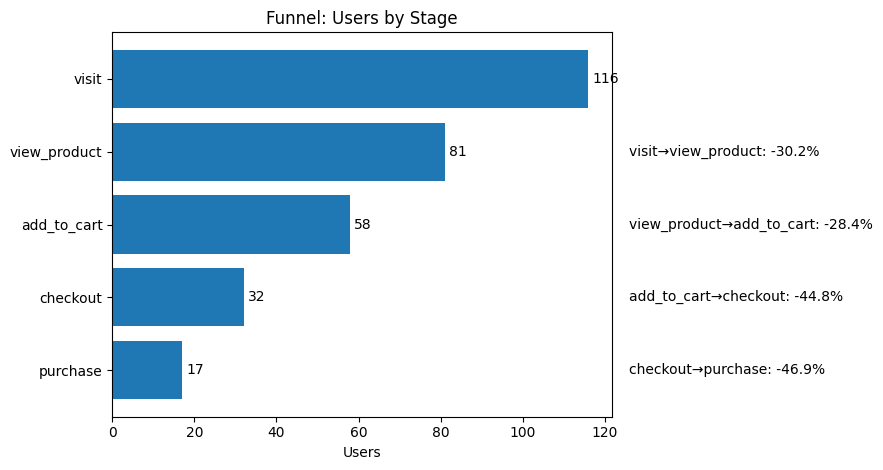

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 4.8))

ax.barh(stages[::-1], users[::-1])
ax.set_title("Funnel: Users by Stage")
ax.set_xlabel("Users")

# annotate user counts
for i, (s, u) in enumerate(zip(stages[::-1], users[::-1])):
    ax.text(u + 1, i, str(u), va="center")

# annotate drop-off % between stages (on the right)
for i in range(1, len(stages)):
    s_prev, s_cur = stages[i-1], stages[i]
    d = drop_off[i]
    ax.text(max(users)+10, len(stages)-1-i, f"{s_prev}→{s_cur}: -{d:.1%}", va="center")

plt.tight_layout()
plt.show()


In [34]:
import plotly.express as px
import pandas as pd

# Replace with YOUR SQL output later
df_device = pd.DataFrame({
    "device": ["desktop", "mobile", "tablet"],
    "overall_conversion": [0.18, 0.10, 0.12]  # example placeholders
})

fig = px.bar(
    df_device,
    x="device",
    y="overall_conversion",
    title="Overall Conversion by Device",
    text=df_device["overall_conversion"].map(lambda x: f"{x:.1%}")
)
fig.update_yaxes(tickformat=".0%")
fig.show()


In [30]:
pip install pymysql

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install mysql-connector-python pandas sqlalchemy


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sqlalchemy import create_engine
import pandas as pd

# MySQL connection details
username = "root"
password = " "      # ⚠️ no spaces
host = "localhost"
port = "3306"
database = "funnel_analysis"

# Create engine
engine = create_engine(
    f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"
)

# ----------------------------
# Write DataFrame to MySQL
# ----------------------------
table_name = "customer"

df.to_sql(
    table_name,
    engine,
    if_exists="replace",   # replace table if exists
    index=False
)

print("Data written successfully")

# ----------------------------
# Read back sample (sanity check)
# ----------------------------
sample_df = pd.read_sql(
    "SELECT * FROM customer LIMIT 5;",
    engine
)

sample_df


Data written successfully


,user_id,session_id,event_time,event_type,device,traffic_source,location
0,U00059,t6uvubthhg3f,2025-12-16 16:08:15,visit,mobile,organic,IN-TN
1,U00059,t6uvubthhg3f,2025-12-16 16:09:30,view_product,mobile,organic,IN-TN
2,U00059,t6uvubthhg3f,2025-12-16 16:12:59,add_to_cart,mobile,organic,IN-TN
3,U00135,9rnxgrfob3y9,2025-12-09 15:00:22,visit,desktop,referral,IN-KA
4,U00135,9rnxgrfob3y9,2025-12-09 15:04:07,view_product,desktop,referral,IN-KA
